# Import

In [17]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg2
import calendar

# DataBase Connection

In [2]:
conn = psycopg2.connect(
    host='hp-dev-db-12sep.cgitnjqny0tw.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='hp_read_user',
    password='hp_@_2023_321',
    database='postgres'
)

# Query to Extract Data

In [3]:
query1 = """select created::date, id, order_status, ordered_via, user_id, order_amount from sales_userorderdata;"""

query2 = """select created::date, order_id, product_name, quantity from sales_userorderproductsizedata"""

In [5]:
e=pd.read_sql(query1,conn)
e.columns = ["created", "order_id", "order_status", "order_channel", "user_id", "order_amount"]
e['created'] = pd.to_datetime(e['created'])
#OrderCount, ASP, AOV, GMV, Acquistion Ratio, Repeat Rate

f = pd.read_sql(query2,conn)
f.columns = ["created", "order_id", "product_name", "quantity"]
f['created'] = pd.to_datetime(f['created'])
OrderSKUMap=f.groupby('order_id').agg(
        SKUs=pd.NamedAgg(column='product_name', aggfunc= 'nunique'),
        Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
    ).reset_index()

# Set Data Columns
e['OrderDate']=e['created'].dt.date
e['OrderDate']=pd.to_datetime(e['OrderDate'])
#Delta Columns
e['DeltaDaysinOrders']=(e.groupby('user_id').OrderDate.shift() - e.OrderDate).dt.days.abs()
e['DeltaOrderValues']=(e.groupby('user_id').order_amount.shift() - e.order_amount)
#Analysis Parameters


x1=e.groupby('user_id').agg(
        LastDate=pd.NamedAgg(column='OrderDate', aggfunc= 'max'),
        FirstDate=pd.NamedAgg(column='OrderDate', aggfunc='min'),

    ).reset_index()


e2=e.merge(x1[['user_id','LastDate','FirstDate']], left_on='user_id', right_on='user_id')
e2=e2.merge(OrderSKUMap, left_on='order_id', right_on='order_id', how='left')

e2['TrxnRank'] = e2.groupby('user_id')['OrderDate'].rank(method='first')
# e2=e2[e2['OrderDate']>='2022-01-01']
# e2=e2[e2['OrderDate']<='2022-12-31']


#fetch metrices

e2['New']=0
e2.loc[e2['TrxnRank']==1,'New']=1
e2['Repeat']=0
e2.loc[e2['TrxnRank']>1,'Repeat']=1
#e2['order_id']=e2['order_id_x']
y2=e2.groupby(["OrderDate", "order_channel"]).agg(
        OrderCounts=pd.NamedAgg(column='order_id', aggfunc= 'count'),
        ActiveUsersCounts=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        TotalOrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
        AOV=pd.NamedAgg(column='order_amount', aggfunc='mean'),
        NewTrxns=pd.NamedAgg(column='New', aggfunc='sum'),
    RepearTrxns=pd.NamedAgg(column='Repeat', aggfunc='sum'),
    Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
SKUCount=pd.NamedAgg(column='SKUs', aggfunc='sum'),

    ).reset_index()

cancelled_orders = e[e['order_status'] == 'Cancelled'].groupby('OrderDate').agg(
    CancellationCount=pd.NamedAgg(column='order_id', aggfunc='count')
).reset_index()

delivered_orders = e[e['order_status'] == 'Delivered'].groupby('OrderDate').agg(
    DeliveryCount=pd.NamedAgg(column='order_id', aggfunc='count')
).reset_index()

y3=e2.groupby(['OrderDate', "user_id"]).agg(
        TotalOrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
    Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
SKUCount=pd.NamedAgg(column='SKUs', aggfunc='sum'),
).reset_index()
y3['UserRank']=y3.groupby('user_id')['OrderDate'].rank(method='first')
y3 = y3.groupby('OrderDate').agg(
    NewUserCount=pd.NamedAgg(column='UserRank', aggfunc=lambda x: (x == 1.0).sum())
)

y2 = y2.merge(cancelled_orders, on='OrderDate', how='left')
y2 = y2.merge(delivered_orders, on='OrderDate', how='left')
y2['CancellationCount'].fillna(0, inplace=True)
y2['DeliveryCount'].fillna(0, inplace=True)

y2=y2.merge(y3, left_on='OrderDate', right_on='OrderDate')

# ordered_via_values = e['order_channel'].unique()
# for ordered_via in ordered_via_values:
#     y2[f'Channel_{ordered_via}'] = 0
# for ordered_via in ordered_via_values:
#     orders_by_channel = e[e['order_channel'] == ordered_via].groupby('OrderDate').size()
#     y2[f'Channel_{ordered_via}'] = y2['OrderDate'].map(orders_by_channel).fillna(0)

y2['NewOrderRatio']=y2['NewTrxns']/y2['OrderCounts']
y2['RepeatOrderRatio']=y2['RepearTrxns']/y2['OrderCounts']
y2['UnitsperOrder']=y2['Quantity']/y2['OrderCounts']
y2['SKUsperOrder']=y2['SKUCount']/y2['OrderCounts']
y2['ASP']=y2['TotalOrderValue']/y2['Quantity']
y2['CancellationRate']=y2['CancellationCount']/y2['OrderCounts']
y2["RepeatUserCount"] = y2["ActiveUsersCounts"] - y2["NewUserCount"]

metrics=['OrderCounts','ActiveUsersCounts','NewUserCount','RepeatUserCount','TotalOrderValue','AOV','ASP','NewOrderRatio','SKUsperOrder','UnitsperOrder','DeliveryCount','CancellationCount', 'CancellationRate']
# for ordered_via in ordered_via_values:
#     metric = f'Channel_{ordered_via}'
#     metrics.append(metric)

C:\Users\CEPL\AppData\Local\Temp\ipykernel_7028\437741552.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  e=pd.read_sql(query1,conn)
C:\Users\CEPL\AppData\Local\Temp\ipykernel_7028\437741552.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  f = pd.read_sql(query2,conn)


In [6]:
y2

,OrderDate,order_channel,OrderCounts,ActiveUsersCounts,TotalOrderValue,AOV,NewTrxns,RepearTrxns,Quantity,SKUCount,CancellationCount,DeliveryCount,NewUserCount,NewOrderRatio,RepeatOrderRatio,UnitsperOrder,SKUsperOrder,ASP,CancellationRate,RepeatUserCount
0,2019-04-01,Android App,151,143,140902.42,933.128609,143,8,1851.0,489.0,6.0,145.0,143,0.947020,0.052980,12.258278,3.238411,76.122323,0.039735,0
1,2019-04-02,Android App,207,199,267573.00,1292.623188,185,22,2780.0,870.0,10.0,197.0,185,0.893720,0.106280,13.429952,4.202899,96.249281,0.048309,14
2,2019-04-03,Android App,256,240,270019.12,1054.762187,215,41,2662.0,880.0,13.0,243.0,215,0.839844,0.160156,10.398438,3.437500,101.434681,0.050781,25
3,2019-04-04,Android App,218,210,265322.04,1217.073578,177,41,2454.0,791.0,2.0,216.0,177,0.811927,0.188073,11.256881,3.628440,108.118191,0.009174,33
4,2019-04-05,Android App,200,193,312976.75,1564.883750,155,45,4942.0,828.0,4.0,196.0,155,0.775000,0.225000,24.710000,4.140000,63.329978,0.020000,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,2023-10-13,Whatsapp,18,5,227.00,12.611111,4,14,5.0,5.0,7.0,0.0,4,0.222222,0.777778,0.277778,0.277778,45.400000,0.388889,1
4839,2023-10-21,Whatsapp,2,2,49.00,24.500000,2,0,1.0,1.0,0.0,0.0,2,1.000000,0.000000,0.500000,0.500000,49.000000,0.000000,0
4840,2023-11-01,Whatsapp,4,1,588.00,147.000000,0,4,4.0,4.0,4.0,0.0,0,0.000000,1.000000,1.000000,1.000000,147.000000,1.000000,1
4841,2023-11-03,Whatsapp,1,1,154.00,154.000000,0,1,1.0,1.0,1.0,0.0,0,0.000000,1.000000,1.000000,1.000000,154.000000,1.000000,1


# Extract Required Data

In [7]:
#Date Filter
y2 = y2[y2["OrderDate"] >= '2022-01-01']
y2 = y2[y2["OrderDate"] <= '2023-01-01']

C:\Users\CEPL\AppData\Local\Temp\ipykernel_7028\2120502567.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Week'] = filtered_data['OrderDate'].dt.strftime('%Y-w%U')


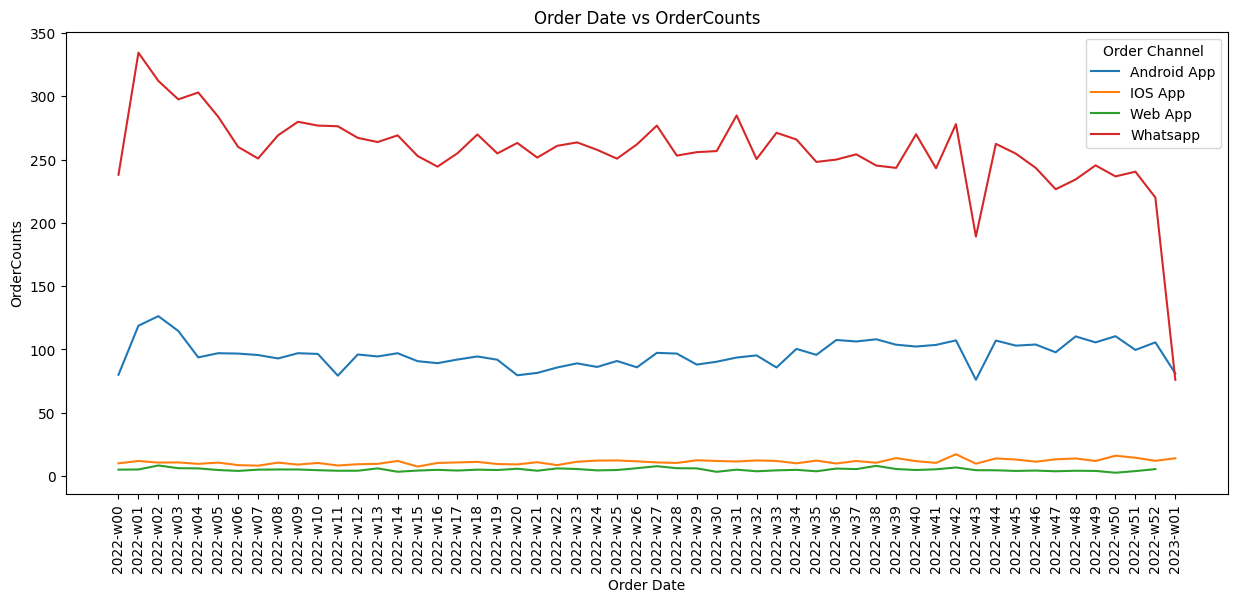

In [43]:
# metrics=['OrderCounts','ActiveUsersCounts','NewUserCount','RepeatUserCount','TotalOrderValue','AOV','ASP','NewOrderRatio','SKUsperOrder','UnitsperOrder','DeliveryCount','CancellationCount', 'CancellationRate']
parameter = "OrderCounts"
filtered_data = y2[["OrderDate", "order_channel", parameter]]

# Day Wise
# filtered_data = y2[["OrderDate", "order_channel", parameter]]
# view = filtered_data.groupby('order_channel')[parameter].mean().reset_index().rename(columns={parameter: f"Daily_Average_{parameter}"})

# Week Wise
filtered_data['Week'] = filtered_data['OrderDate'].dt.strftime('%Y-w%U')
filtered_data = filtered_data.groupby(['Week', 'order_channel'])[parameter].mean().reset_index()
view = filtered_data.groupby('order_channel')[parameter].mean().reset_index().rename(columns={parameter: f"Weekly_Average_{parameter}"})

# Month Wise
# filtered_data['Month'] = filtered_data['OrderDate'].dt.strftime('%Y-%m')
# filtered_data = filtered_data.groupby(['Month', 'order_channel'])[parameter].mean().reset_index()
# view = filtered_data.groupby('order_channel')[parameter].mean().reset_index().rename(columns={parameter: f"Monthly_Average_{parameter}"})

plt.figure(figsize=(15, 6))
sns.lineplot(data=filtered_data, x=(filtered_data.columns)[0], y=parameter, hue='order_channel')
plt.title(f'Order Date vs {parameter}')
plt.xlabel('Order Date')
plt.xticks(rotation=90)
plt.ylabel(parameter)
plt.legend(title='Order Channel')
plt.show()

In [44]:
view

,order_channel,Weekly_Average_OrderCounts
0,Android App,96.550265
1,IOS App,11.210317
2,Web App,4.980683
3,Whatsapp,256.388007


In [3]:
# query1 = """select created::date as order_date,
# 	id as order_id,
#     ordered_via as channel
#     from sales_userorderdata
# 	"""

In [4]:
# data = pd.read_sql(query1, conn)
# data['order_date'] = pd.to_datetime(data['order_date'])
# data = data.sort_values('order_date')

C:\Users\CEPL\AppData\Local\Temp\ipykernel_9312\1932698707.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query1, conn)


In [5]:
# data

,order_date,order_id,channel
417325,2019-04-01,176404,Android App
467874,2019-04-01,214145,Android App
96022,2019-04-01,193485,Android App
79057,2019-04-01,161200,Android App
468391,2019-04-01,214562,Android App
...,...,...,...
130871,2023-11-01,703031,Whatsapp
129724,2023-11-01,703030,Whatsapp
132506,2023-11-03,703034,Whatsapp
137247,2023-11-08,703036,Whatsapp


# Distribution Plot

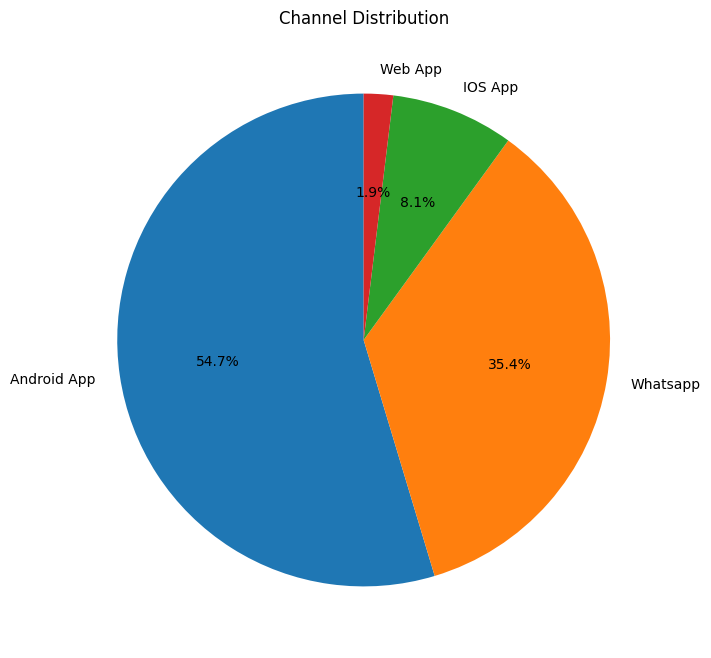

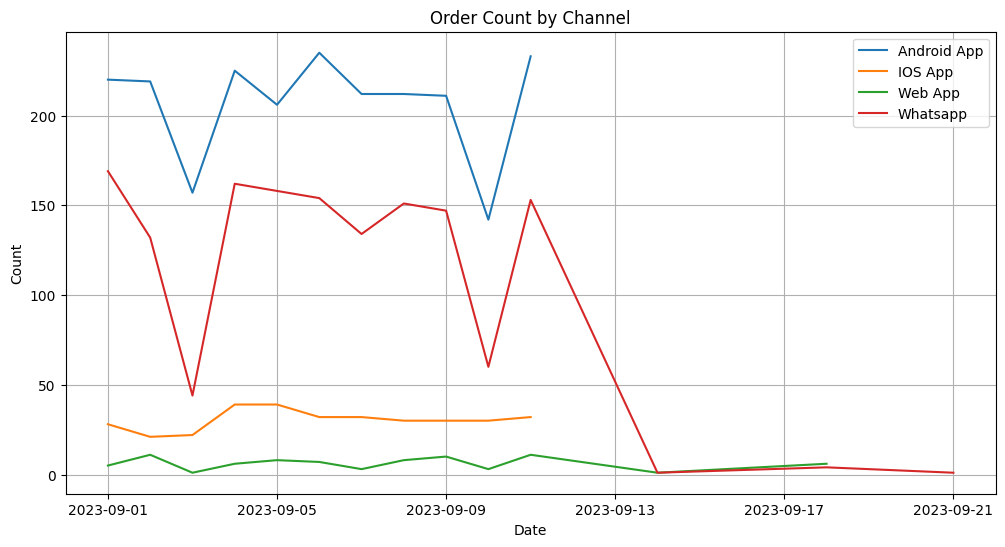

In [6]:
# # Date Filter
# start_date = '2023-09-01'
# end_date = '2023-09-30'
# start_date = pd.to_datetime(start_date)
# end_date = pd.to_datetime(end_date)
# filtered_data = data[(data['order_date'] >= start_date) & (data['order_date'] <= end_date)]

# channel_counts = filtered_data['channel'].value_counts()
# plt.figure(figsize=(8, 8))
# plt.pie(channel_counts, labels=channel_counts.index, autopct='%1.1f%%', startangle=90)
# plt.title('Channel Distribution')
# plt.show()

# plt.figure(figsize=(12, 6))
# for channel, channel_data in filtered_data.groupby('channel'):
#     channel_data = channel_data.groupby('order_date').size()
#     plt.plot(channel_data.index, channel_data.values, label=channel)

# plt.xlabel('Date')
# plt.ylabel('Count')
# plt.title('Order Count by Channel')
# plt.legend()
# plt.grid(True)
# plt.show()

In [7]:
# view = filtered_data.groupby("channel").agg(
#     OrderCount = pd.NamedAgg(column='order_id', aggfunc='nunique')).reset_index()
# view["OrderRatio"] = view["OrderCount"]*100/view["OrderCount"].sum()
# view

,channel,OrderCount,OrderRatio
0,Android App,2272,54.654799
1,IOS App,335,8.058696
2,Web App,80,1.924465
3,Whatsapp,1470,35.362040


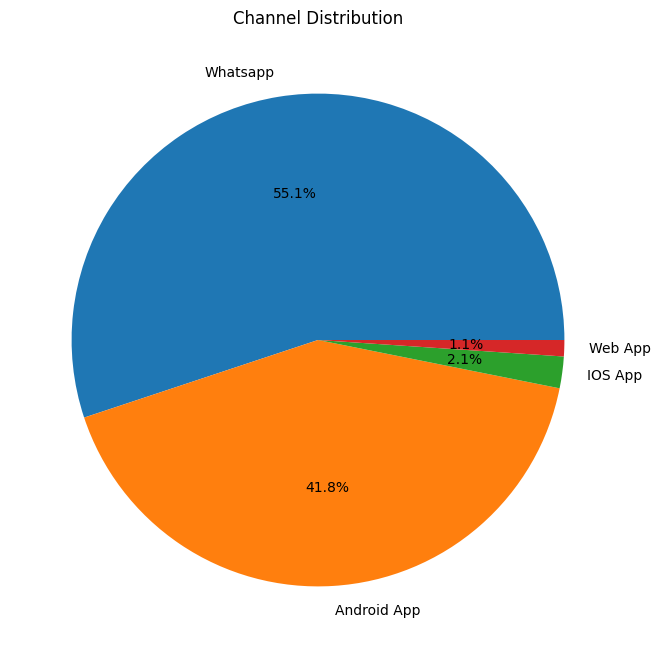

In [8]:
# #Over all

# channel_counts = data['channel'].value_counts()
# plt.figure(figsize=(8, 8))
# plt.pie(channel_counts, labels=channel_counts.index, autopct='%1.1f%%', startangle=0)
# plt.title('Channel Distribution')
# plt.show()

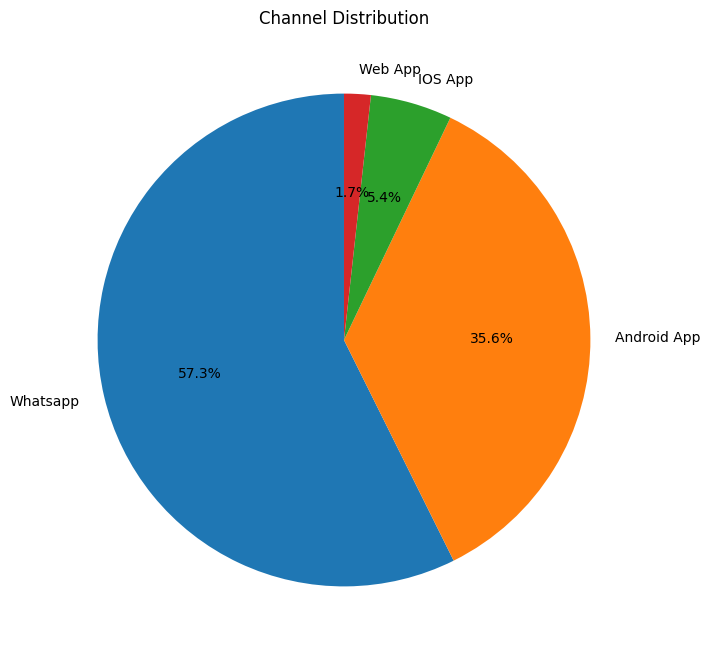

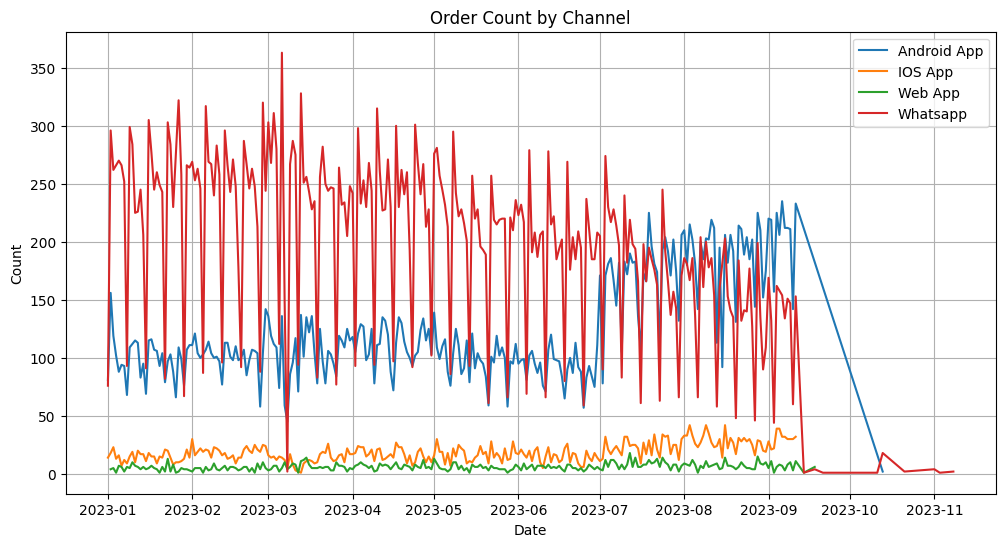

In [9]:
# # Yearly

# year = 2023
# filtered_data = data[data['order_date'].dt.year == year]

# channel_counts = filtered_data['channel'].value_counts()
# plt.figure(figsize=(8, 8))
# plt.pie(channel_counts, labels=channel_counts.index, autopct='%1.1f%%', startangle=90)
# plt.title('Channel Distribution')
# plt.show()

# plt.figure(figsize=(12, 6))
# for channel, channel_data in filtered_data.groupby('channel'):
#     channel_data = channel_data.groupby('order_date').size()
#     plt.plot(channel_data.index, channel_data.values, label=channel)

# plt.xlabel('Date')
# plt.ylabel('Count')
# plt.title('Order Count by Channel')
# plt.legend()
# plt.grid(True)
# plt.show()

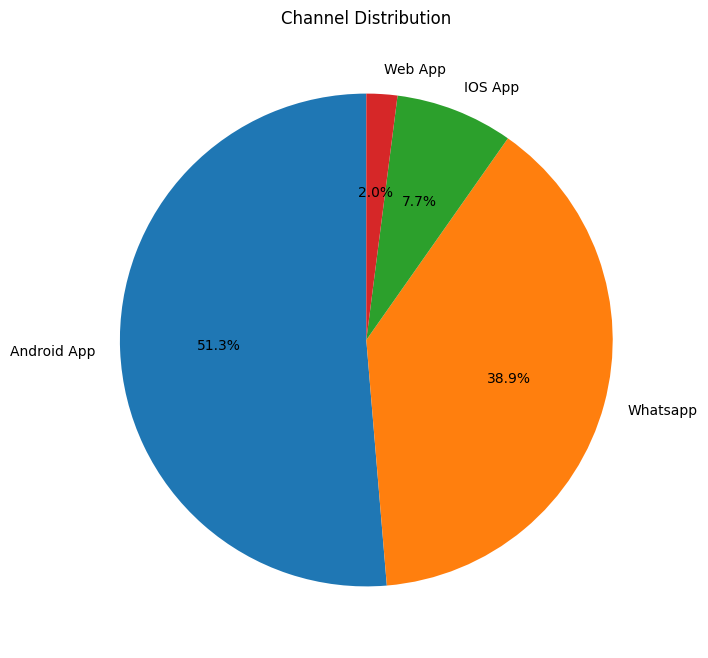

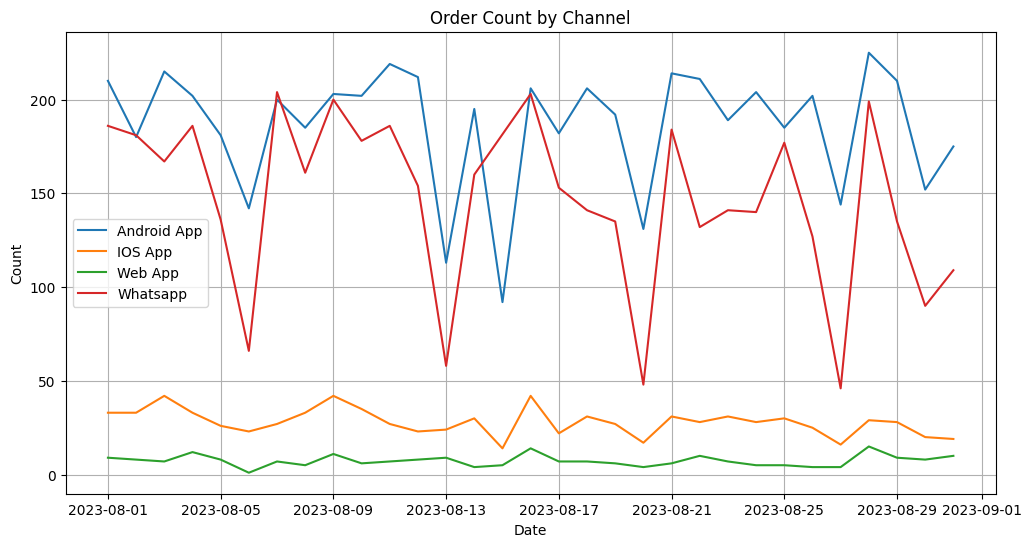

In [10]:
# # Monthly

# year = 2023
# month = 8
# filtered_data = data[(data['order_date'].dt.year == year) & (data['order_date'].dt.month == month)]

# channel_counts = filtered_data['channel'].value_counts()
# plt.figure(figsize=(8, 8))
# plt.pie(channel_counts, labels=channel_counts.index, autopct='%1.1f%%', startangle=90)
# plt.title('Channel Distribution')
# plt.show()

# plt.figure(figsize=(12, 6))
# for channel, channel_data in filtered_data.groupby('channel'):
#     channel_data = channel_data.groupby('order_date').size()
#     plt.plot(channel_data.index, channel_data.values, label=channel)

# plt.xlabel('Date')
# plt.ylabel('Count')
# plt.title('Order Count by Channel')
# plt.legend()
# plt.grid(True)
# plt.show()

# Monthly Distribution Table

In [11]:
# grouped = data.groupby(['channel', data['order_date'].dt.strftime('%Y-%m')])['order_id'].count().reset_index()
# result = grouped.groupby(['order_date']).agg(
#     total=pd.NamedAgg(column='order_id', aggfunc='sum')).reset_index()
# grouped = grouped.merge(result, on=['order_date'], how='left')
# month_table = pd.pivot_table(grouped, values='order_id', columns='channel', index='order_date', fill_value=0)
# month_table = month_table.div(month_table.sum(axis=1), axis=0) * 100
# month_table = pd.merge(grouped[["order_date", "total"]], month_table, on = "order_date", how = "outer")
# month_table = month_table.drop_duplicates()

# month_table

# Weekly Distribution Table

In [12]:
# grouped = data.groupby(['channel', data['order_date'].dt.strftime('%Y-w%U')])['order_id'].count().reset_index()
# result = grouped.groupby(['order_date']).agg(
#     total=pd.NamedAgg(column='order_id', aggfunc='sum')).reset_index()
# grouped = grouped.merge(result, on=['order_date'], how='left')
# week_table = pd.pivot_table(grouped, values='order_id', columns='channel', index='order_date', fill_value=0)
# week_table = week_table.div(week_table.sum(axis=1), axis=0) * 100
# week_table = pd.merge(grouped[["order_date", "total"]], week_table, on = "order_date", how = "outer")
# week_table = week_table.drop_duplicates()
# week_table = week_table.rename(columns={'order_date': 'order_week'})
# week_table

,order_week,total,Android App,IOS App,Web App,Whatsapp
0,2019-w13,1207,100.0,0.0,0.000000,0.000000
1,2019-w14,1288,100.0,0.0,0.000000,0.000000
2,2019-w15,1202,100.0,0.0,0.000000,0.000000
3,2019-w16,1276,100.0,0.0,0.000000,0.000000
4,2019-w17,1424,100.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...
718,2023-w38,11,0.0,0.0,54.545455,45.454545
720,2023-w40,2,0.0,0.0,0.000000,100.000000
721,2023-w42,2,0.0,0.0,0.000000,100.000000
722,2023-w44,5,0.0,0.0,0.000000,100.000000


In [13]:
# Alert
avg_metric = week_table.tail(6).iloc[:, 1:].mean().round(3)
avg_metric = pd.DataFrame(avg_metric).T
avg_metric.insert(0, "order_week", ["Last 6 weeks Average"])
alert = pd.concat([avg_metric, week_table.tail(1)])
alert

,order_week,total,Android App,IOS App,Web App,Whatsapp
0,Last 6 weeks Average,7.167,1.587,0.0,9.091,89.322
723,2023-w45,2.000,0.000,0.0,0.000,100.000
